# On Deck ML Challenge
## Goals
- Build the first iteration of a recommender system that could suggest top-recommended movies to users.
- Provide a GitHub repo (private is fine) with the working model and some description of how to reproduce training/testing steps.
- Provide written answers to these questions:
  - A brief justification of the chosen model and the scoring metric. What alternatives would be worth exploring?
  - What would be your next steps to improve the recommendation quality?

[Dataset link](https://www.dropbox.com/s/vi7lktdxx0r97o4/od-challenge.tar.gz?dl=1).

## Notes

- You define the technical details of the solution: the model, feature set, test/train split, normalization, loss, scoring metric.
- You're not expected to use as much features as possible. Explore the data and take what works best for your approach.
- You're not expected to produce a model with perfect scores. It's enough to pick a sensible model, make a few tweak iterations, produce some results, and outline a path to improve it.

## Technical constraints

- Python 3.8+, Torch/TensorFlow/Keras.
- The model, the traing and testing code should be in Jupyter notebooks. Everything else may be in notebooks or python files.
- If trainng takes more than an hour on a laptop, provide the trained model and the code to load it.

## 1. Import Libraries and Dataset

In [1]:
# All imports will be declared here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [196]:
"""
Note: All files were converted to CSV in order to use load them on google colab. Main reasons to use Colab:
- Pickle was not compatible because Colab uses Python 3.7
- My Mac M1 has Python 3.8 however, it does not has GPU and M1 is not compatible with Tensorflow
- Amazon Sagemaker defaults instances also uses up to Python 3.7
- My time has been short to set up another cloud from scratch just because of the P38 requirement
- Python 3.7 is almost identical to Python 3.8


aggs=pickle.load(open('./data/aggs.pickle', 'rb'))
labels=pickle.load(open('./data/labels.pickle', 'rb'))
movies=pickle.load(open('./data/movies.pickle', 'rb'))
teams=pickle.load(open('./data/teams.pickle', 'rb'))

files = [aggs, labels, movies, teams]
names = ['aggs', 'labels', 'movies', 'teams']
for f, fname in zip(files, names):
    f.to_csv(f'./data/{fname}.csv', index=False)
"""

"\nNote: All files were converted to CSV in order to use load them on google colab. Main reasons to use Colab:\n- Pickle was not compatible because Colab uses Python 3.7\n- My Mac M1 has Python 3.8 however, it does not has GPU and M1 is not compatible with Tensorflow\n- Amazon Sagemaker defaults instances also uses up to Python 3.7\n- My time has been short to set up another cloud from scratch just because of the P38 requirement\n- Python 3.7 is almost identical to Python 3.8\n\n\naggs=pickle.load(open('./data/aggs.pickle', 'rb'))\nlabels=pickle.load(open('./data/labels.pickle', 'rb'))\nmovies=pickle.load(open('./data/movies.pickle', 'rb'))\nteams=pickle.load(open('./data/teams.pickle', 'rb'))\n\nfiles = [aggs, labels, movies, teams]\nnames = ['aggs', 'labels', 'movies', 'teams']\nfor f, fname in zip(files, names):\n    f.to_csv(f'./data/{fname}.csv', index=False)\n"

In [3]:
!git clone https://github.com/WittmannF/od-ml-challenge

Cloning into 'od-ml-challenge'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 9), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
cd od-ml-challenge

/content/od-ml-challenge


In [5]:
aggs=pd.read_csv('./data/aggs.csv')
labels=pd.read_csv('./data/labels.csv')
movies=pd.read_csv('./data/movies.csv')
teams=pd.read_csv('./data/teams.csv')

## 2. Data Preprocessing and Exploratory Data Analysis

### Aggregated Ratings

In [6]:
aggs.head()

,movie_id,rating_average,rating_count,demographic
0,109830,8.8,1870499,total
1,109830,8.8,1032446,gender_m
2,109830,8.7,269593,gender_f
3,109830,8.9,1215,age_0_17
4,109830,8.9,344804,age_18_29


In [7]:
aggs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28557 entries, 0 to 28556
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        28557 non-null  int64  
 1   rating_average  28557 non-null  float64
 2   rating_count    28557 non-null  int64  
 3   demographic     28557 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 892.5+ KB


In [8]:
aggs.describe()

,movie_id,rating_average,rating_count
count,2.855700e+04,28557.000000,2.855700e+04
mean,5.877748e+05,6.802889,5.273596e+04
std,8.578465e+05,0.992756,1.110895e+05
min,4.170000e+02,1.000000,1.000000e+00
25%,9.501600e+04,6.200000,3.614000e+03
50%,1.987810e+05,6.900000,1.646700e+04
75%,7.954210e+05,7.500000,5.278800e+04
max,6.644200e+06,10.000000,2.421280e+06


### User Ratings

In [9]:
labels.head()

,movie_id,user_id,rating
0,116367,1,3.0
1,114287,1,5.0
2,109370,1,5.0
3,112851,1,5.0
4,112508,1,5.0


In [10]:
labels.describe()

,movie_id,user_id,rating
count,4.223700e+04,42237.000000,42237.000000
mean,3.872995e+05,303.150200,3.610318
std,6.451020e+05,177.654595,1.063750
min,4.170000e+02,1.000000,0.500000
25%,1.004050e+05,144.000000,3.000000
50%,1.186360e+05,305.000000,4.000000
75%,3.502580e+05,454.000000,4.500000
max,6.644200e+06,610.000000,5.000000


In [11]:
labels.movie_id.value_counts()

111161     200
109830     189
110912     183
102926     163
133093     147
          ... 
36027        2
107566       2
80861        2
2309021      2
1672218      2
Name: movie_id, Length: 4107, dtype: int64

In [12]:
labels.user_id.value_counts()

279    150
247    149
41     147
7      147
475    146
      ... 
245     14
324     14
53      14
207     14
544     12
Name: user_id, Length: 610, dtype: int64

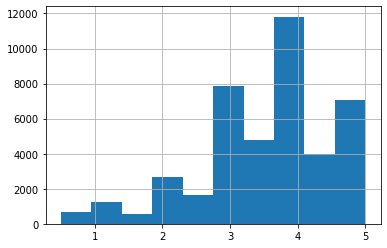

In [13]:
labels.rating.hist()

### Cast & Crew

In [14]:
teams.head()

,movie_id,person_role,person_id,person_name
0,109830,actor,158,NaN
1,109830,actor,705,NaN
2,109830,actor,641,NaN
3,109830,actor,398,NaN
4,109830,actor,931508,NaN


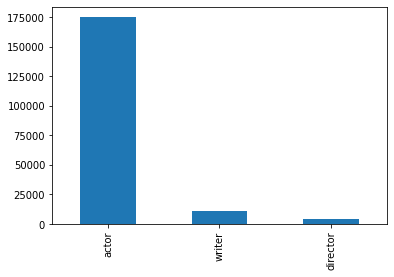

In [15]:
teams.person_role.value_counts().plot.bar()

In [16]:
teams.movie_id.value_counts()

401711     134
1333125    133
374463     115
362120     110
1300854    109
          ... 
439          3
2017038      3
59026        2
248808       2
832903       2
Name: movie_id, Length: 4107, dtype: int64

### Movies Info

In [17]:
movies.head()

,movie_id,title,genres,year,synopsis
0,114709,Toy Story,"{'Adventure', 'Children', 'Comedy', 'Animation...",1995,A boy called Andy Davis (voice: John Morris) u...
1,113497,Jumanji,"{'Adventure', 'Children', 'Fantasy'}",1995,The film begins in 1869 in the town of Brantfo...
2,113277,Heat,"{'Crime', 'Action', 'Thriller'}",1995,An inbound Los Angeles Blue Line train pulls i...
3,114319,Sabrina,"{'Romance', 'Comedy'}",1995,"Sabrina Fairchild (Julia Ormond), is the Larra..."
4,112302,Tom and Huck,"{'Adventure', 'Children'}",1995,The film opens with Injun Joe (Eric Schweig) a...


In [18]:
movies['genres']=movies.genres.astype(str).apply(lambda x: x.replace('{', '').replace('}', ''))

In [19]:
movies_genres=movies.genres.str.get_dummies(',')
movies_genres

,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4103,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4104,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4105,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


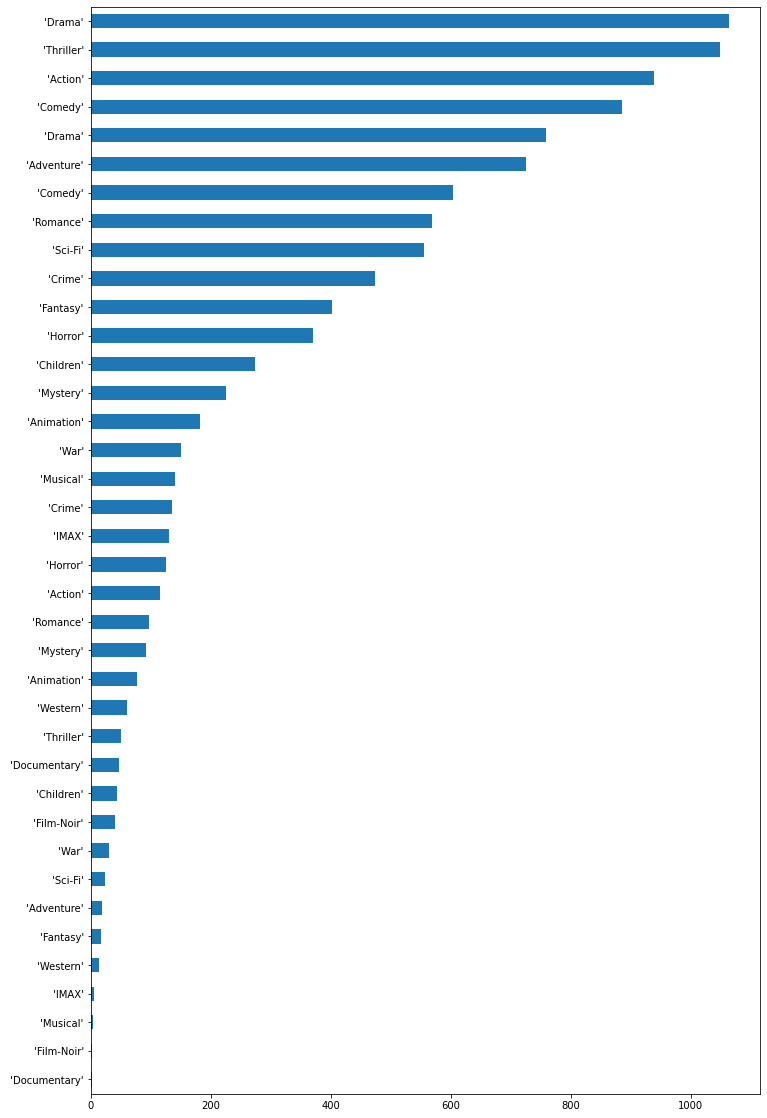

In [20]:
movies_genres.sum().sort_values().plot.barh(figsize=(12, 20))

In [21]:
movies=pd.concat([movies.drop('genres', axis=1), movies_genres], axis=1)
movies.head()

,movie_id,title,year,synopsis,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
0,114709,Toy Story,1995,A boy called Andy Davis (voice: John Morris) u...,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,113497,Jumanji,1995,The film begins in 1869 in the town of Brantfo...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,113277,Heat,1995,An inbound Los Angeles Blue Line train pulls i...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,114319,Sabrina,1995,"Sabrina Fairchild (Julia Ormond), is the Larra...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,112302,Tom and Huck,1995,The film opens with Injun Joe (Eric Schweig) a...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3. Recommender System

We have multiple possibilities here ([ref1](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system), [ref2](https://developers.google.com/machine-learning/recommendation/)):
### Demographic Filtering
Offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- Pros
  - Simplicity
- Cons
  - Since each user is different , this approach is considered to be *too* simple. 

### Content Based Filtering
They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- Pros
  - The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users.
  - The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.
- Cons
  - Since the feature representation of the items are hand-engineered to some extent, this technique requires a lot of domain knowledge. Therefore, the model can only be as good as the hand-engineered features.
  - The model can only make recommendations based on existing interests of the user. In other words, the model has limited ability to expand on the users' existing interests


### Collaborative Filtering
This system matches persons with similar interests and provides recommendations based on this matching. 
  - Pros
    - Collaborative filters do not require item metadata like its content-based counterparts.
    - The model can help users discover new interests. In isolation, the ML system may not know the user is interested in a given item, but the model might still recommend it because similar users are interested in that item.
    - To some extent, the system needs only the feedback matrix to train a matrix factorization model. In particular, the system doesn't need contextual features. In practice, this can be used as one of multiple candidate generators.
  - Cons
    - The [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems))
    - Does not use meaninful information from metadata. However, although not simple, we can [augment the input matrix with features](https://developers.google.com/machine-learning/recommendation/collaborative/summary). 

Since one of our requirements is to use a deep learning library, let's explore a Colaborative Filtering approach. Even though there's the cold start problem, we can match new users by asking them their top 3 favorite movies and match with with the movie embedding that has been built after training the network. Alternative strategies such as projections and heuristics are available in [this reference](https://developers.google.com/machine-learning/recommendation/collaborative/summary)

In [22]:
# all modeling related imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [126]:
data = labels.copy()

In [127]:
data.head()

,movie_id,user_id,rating
0,116367,1,3.0
1,114287,1,5.0
2,109370,1,5.0
3,112851,1,5.0
4,112508,1,5.0


Since the movie id is not in a continuous range, let's factorize it in order to be compatible with the embedding layer:

In [25]:
#movie_id_to_index, index_to_movie_id = pd.factorize(data.movie_id)

In [128]:
#movies.movie_id.values

In [129]:
index_to_movie_id=movies.movie_id.values

In [139]:
movie_id_to_index=data.movie_id.apply(lambda x: index_to_movie_id.tolist().index(x)).values

In [140]:
movie_id_to_index

array([  34,   58,   62, ..., 3985, 3995, 4023])

In [141]:
data['movie_id']=movie_id_to_index

In [142]:
data.head()

,movie_id,user_id,rating
0,34,1,3.0
1,58,1,5.0
2,62,1,5.0
3,67,1,5.0
4,85,1,5.0


In [143]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [144]:
n_users = len(data.user_id.unique())
n_movies = len(data.movie_id.unique())

In [145]:
n_users

610

In [146]:
n_movies

4107

In [147]:
# creating the movie embedding
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies, 10, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 10, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [148]:
mc = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, \
                     verbose=1, monitor='val_loss')

In [149]:
history = model.fit([train.user_id, train.movie_id], 
                    train.rating,
                    validation_data=([test.user_id, test.movie_id], test.rating), 
                    epochs=20, 
                    verbose=1,
                    callbacks=[mc])

Epoch 1/20
1056/1056 [==============================] - 6s 5ms/step - loss: 14.0627 - val_loss: 13.6080

Epoch 00001: val_loss improved from inf to 13.60797, saving model to best_model.hdf5
Epoch 2/20
1056/1056 [==============================] - 5s 5ms/step - loss: 11.0683 - val_loss: 8.2854

Epoch 00002: val_loss improved from 13.60797 to 8.28539, saving model to best_model.hdf5
Epoch 3/20
1056/1056 [==============================] - 5s 4ms/step - loss: 5.7629 - val_loss: 4.3391

Epoch 00003: val_loss improved from 8.28539 to 4.33907, saving model to best_model.hdf5
Epoch 4/20
1056/1056 [==============================] - 5s 5ms/step - loss: 3.0034 - val_loss: 2.7190

Epoch 00004: val_loss improved from 4.33907 to 2.71901, saving model to best_model.hdf5
Epoch 5/20
1056/1056 [==============================] - 4s 4ms/step - loss: 1.8578 - val_loss: 2.0250

Epoch 00005: val_loss improved from 2.71901 to 2.02497, saving model to best_model.hdf5
Epoch 6/20
1056/1056 [======================

In [150]:
model.load_weights('best_model.hdf5')

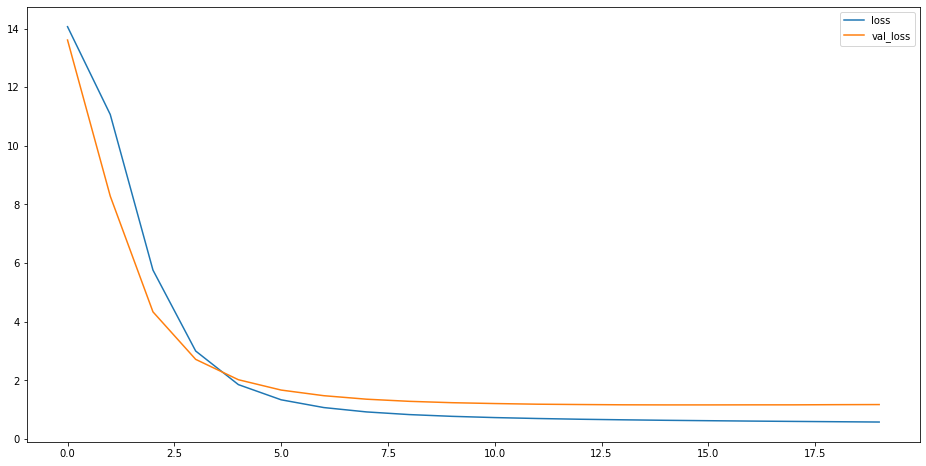

In [151]:
pd.DataFrame(history.history).plot(figsize=(16, 8))

Let's add more complexity to the model itself in order to check if we can improve the validation loss.

In [152]:
#def create_model_nn():
    # creating the movie embedding
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies, 10, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 10, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
#fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc1)

# Create model and compile it
model2 = Model([user_input, movie_input], out)
    #model2.compile('adam', 'mean_squared_error')
#    return model

#model_2 = create_model_nn()

In [153]:
model2.compile(Adam(1e-2), 'mean_squared_error')

In [154]:
mc = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, \
                     verbose=1, monitor='val_loss')

history = model2.fit([train.user_id, train.movie_id], 
                    train.rating,
                    validation_data=([test.user_id, test.movie_id], test.rating), 
                    epochs=10, 
                    verbose=1,
                    callbacks=[mc])

Epoch 1/10
1056/1056 [==============================] - 6s 5ms/step - loss: 1.0733 - val_loss: 0.9056

Epoch 00001: val_loss improved from inf to 0.90557, saving model to best_model.hdf5
Epoch 2/10
1056/1056 [==============================] - 5s 5ms/step - loss: 0.8322 - val_loss: 0.9060

Epoch 00002: val_loss did not improve from 0.90557
Epoch 3/10
1056/1056 [==============================] - 5s 4ms/step - loss: 0.7714 - val_loss: 0.9550

Epoch 00003: val_loss did not improve from 0.90557
Epoch 4/10
1056/1056 [==============================] - 5s 5ms/step - loss: 0.7247 - val_loss: 0.9048

Epoch 00004: val_loss improved from 0.90557 to 0.90483, saving model to best_model.hdf5
Epoch 5/10
1056/1056 [==============================] - 5s 5ms/step - loss: 0.6808 - val_loss: 0.8838

Epoch 00005: val_loss improved from 0.90483 to 0.88382, saving model to best_model.hdf5
Epoch 6/10
1056/1056 [==============================] - 5s 5ms/step - loss: 0.6309 - val_loss: 0.9319

Epoch 00006: val_los

In [155]:
model2.load_weights('best_model.hdf5')

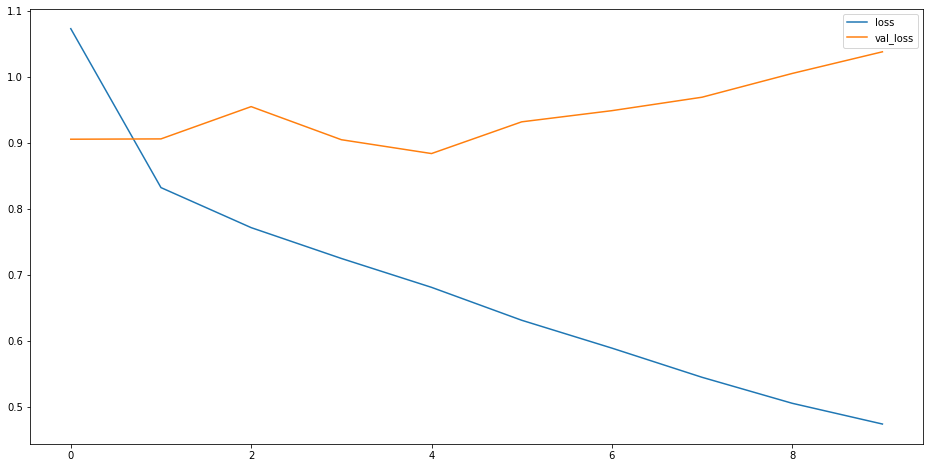

In [156]:
pd.DataFrame(history.history).plot(figsize=(16, 8))

We can see that by adding more complexity the model was able to outpass the previous best validation loss, however, we have to be careful with overfitting. By using the model checkpointer, we saved only the model with the best validation loss

## Making Recommendations for Existing Users

In [157]:
# Creating dataset for making recommendations for the first user
movie_data = np.array(list(set(data.movie_id)))
movie_data[:5]

array([0, 1, 2, 3, 4])

In [158]:
user = np.array([1 for i in range(len(movie_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [159]:
predictions = model2.predict([user, movie_data])

predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([ 463, 3176, 2111, 3601,  378])

## Making Recommendations for New Users (Cold Start Problem)
I will make a movie recommendation to myself. Let me first select some movies that I like:

In [160]:
movies_i_like=['Shawshank Redemption, The']
                #'Léon: The Professional (a.k.a. The Professional) (Léon)',
               #'Shawshank Redemption, The',
               #'Forrest Gump']


Next, let's get their respective movie ids

In [161]:
my_movies_id=movies.query('title in @movies_i_like').movie_id.values
my_movies_id

array([111161])

Then, let's get their respective indexes:

In [162]:
n_movies

4107

In [163]:
index_to_movie_id

array([ 114709,  113497,  113277, ..., 3778644, 5095030, 4912910])

In [165]:
my_movies_indexes=[index_to_movie_id.tolist().index(mid) for mid in my_movies_id]
my_movies_indexes

[129]

Next, let's get the movie embedding layer to lookup the most similar ones to those I like.

In [166]:
movie_em = model.get_layer('Movie-Embedding')
movie_em_weights = movie_em.get_weights()[0]

In [167]:
movie_em_weights=pd.DataFrame(movie_em_weights)
movie_em_weights

,0,1,2,3,4,5,6,7,8,9
0,-0.474187,0.209290,0.574534,0.433717,0.552828,-0.554247,-0.520085,0.501072,-0.542649,0.290927
1,-0.511913,0.223997,0.481039,0.408815,0.481068,-0.529206,-0.490926,0.570379,-0.441840,0.294413
2,-0.428229,0.778437,0.565723,0.430615,0.411866,-0.484240,-0.659601,0.415306,-0.546526,0.475204
3,-0.454445,0.210972,0.356857,0.345591,0.483383,-0.441238,-0.423346,0.440968,-0.449146,0.337258
4,-0.282394,0.264641,0.384878,0.352463,0.311708,-0.330422,-0.337982,0.372557,-0.256763,0.341838
...,...,...,...,...,...,...,...,...,...,...
4102,-0.423576,-0.154357,0.382813,0.382293,0.399892,-0.424742,-0.389875,0.446403,-0.407565,0.274228
4103,-0.538136,-0.217407,0.484198,0.508693,0.440488,-0.508742,-0.377625,0.462368,-0.429619,0.312721
4104,-0.319129,-0.384520,0.367108,0.366512,0.377633,-0.381103,-0.457116,0.387336,-0.460717,0.087190
4105,-0.488435,-0.319368,0.412898,0.463188,0.428933,-0.437812,-0.495448,0.460149,-0.290655,0.134859


Then, I will take their average and lookup the most similar ones using cosine similarity:

In [170]:
my_movie_weights_avg=my_movie_weights.mean()
my_movie_weights_avg

0   -0.480737
1    0.871578
2    0.567899
3    0.661979
4    0.603168
5   -0.559510
6   -0.576694
7    0.387215
8   -0.621593
9    0.456535
dtype: float32

In [173]:
from numpy.linalg import norm

cos_sim = lambda a,b: np.dot(a, b)/(norm(a)*norm(b))
x=my_movie_weights_avg.values
y=movie_em_weights.iloc[129].values
cos_sim(x, y)

1.0

In [174]:
my_movie_weights_avg

0   -0.480737
1    0.871578
2    0.567899
3    0.661979
4    0.603168
5   -0.559510
6   -0.576694
7    0.387215
8   -0.621593
9    0.456535
dtype: float32

In [175]:
cos_sim_values=movie_em_weights.apply(lambda x: cos_sim(x, my_movie_weights_avg.values), axis=1)
cos_sim_values

0       0.926629
1       0.922157
2       0.986532
3       0.933022
4       0.955703
          ...   
4102    0.801863
4103    0.785159
4104    0.658010
4105    0.707526
4106    0.682172
Length: 4107, dtype: float64

In [176]:
recommendation=pd.DataFrame(cos_sim_values, columns=['cosine_similarity'])

In [177]:
recommendation['movie_index']=movie_em_weights.index

In [178]:
recommendation['movie_id']=index_to_movie_id
recommendation

,cosine_similarity,movie_index,movie_id
0,0.926629,0,114709
1,0.922157,1,113497
2,0.986532,2,113277
3,0.933022,3,114319
4,0.955703,4,112302
...,...,...,...
4102,0.801863,4102,3606756
4103,0.785159,4103,5463162
4104,0.658010,4104,3778644
4105,0.707526,4105,5095030


In [180]:
recommendation=recommendation.join(movies.set_index('movie_id'), on='movie_id', rsuffix='_right')
recommendation

,cosine_similarity,movie_index,movie_id,title,year,synopsis,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western',movie_index_right
0,0.926629,0,114709,Toy Story,1995,A boy called Andy Davis (voice: John Morris) u...,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255
1,0.922157,1,113497,Jumanji,1995,The film begins in 1869 in the town of Brantfo...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,470
2,0.986532,2,113277,Heat,1995,An inbound Los Angeles Blue Line train pulls i...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,610
3,0.933022,3,114319,Sabrina,1995,"Sabrina Fairchild (Julia Ormond), is the Larra...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,667
4,0.955703,4,112302,Tom and Huck,1995,The film opens with Injun Joe (Eric Schweig) a...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,0.801863,4102,3606756,Incredibles 2,2018,Agent Rick Dicker (Jonathan Banks) is intervie...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1286
4103,0.785159,4103,5463162,Deadpool 2,2018,After successfully working as the mercenary De...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1287
4104,0.658010,4104,3778644,Solo: A Star Wars Story,2018,"In this second 'Star Wars' stand-alone, spin-o...",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2047
4105,0.707526,4105,5095030,Ant-Man and the Wasp,2018,The film opens in 1987 as Hank Pym (Michael Do...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1822


In [181]:
recommendation.sort_values('cosine_similarity', ascending=False).head(10)

,cosine_similarity,movie_index,movie_id,title,year,synopsis,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western',movie_index_right
129,1.000000,129,111161,"Shawshank Redemption, The",1994,"In 1947, Andy Dufresne (Tim Robbins), a banker...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,120
1122,0.997100,1122,167404,"Sixth Sense, The",1999,"Dr. Malcolm Crowe (Bruce Willis), a prominent ...",0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,374
1209,0.996865,1209,120601,Being John Malkovich,1999,Craig Schwartz (John Cusack) is an unsuccessfu...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1538
230,0.995999,230,103064,Terminator 2: Judgment Day,1991,Scenes described in red text appear only in th...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,284
1337,0.995556,1337,181984,Boiler Room,2000,Seth Davis (Giovanni Ribisi) is a 19-year-old ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1687
57,0.995093,57,112384,Apollo 13,1995,"The story opens on July 20, 1969, in the home ...",0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,262
1584,0.995031,1584,208092,Snatch,2000,The film opens as we see boxing promoter Turki...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,665
1933,0.994871,1933,271219,Tadpole,2002,Oscar Grubman (Aaron Stanford) is a 15-year-ol...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3059
197,0.994692,197,107497,Malice,1993,A young college coed is leaving school for the...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,327
1639,0.994009,1639,209144,Memento,2000,This is a complex story about Leonard Shelby (...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,699


Hence, the movies that are being recommended to myself are:

In [182]:
recommendation.sort_values('cosine_similarity', ascending=False).head(10).title

129      Shawshank Redemption, The
1122              Sixth Sense, The
1209          Being John Malkovich
230     Terminator 2: Judgment Day
1337                   Boiler Room
57                       Apollo 13
1584                        Snatch
1933                       Tadpole
197                         Malice
1639                       Memento
Name: title, dtype: object

Since we have extra features, an simple improvement we can perform in the recommendation system is to add the movie genres as features in addition to the embedding weights for performing the cosine similarity:

In [190]:
movie_em_weights_genres=pd.concat([movie_em_weights, movies_genres], axis=1)
my_movie_weights=movie_em_weights_genres.iloc[my_movies_indexes]
my_movie_weights_avg=my_movie_weights.mean()

In [193]:
movie_em_weights_genres

,0,1,2,3,4,5,6,7,8,9,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
0,-0.474187,0.209290,0.574534,0.433717,0.552828,-0.554247,-0.520085,0.501072,-0.542649,0.290927,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.511913,0.223997,0.481039,0.408815,0.481068,-0.529206,-0.490926,0.570379,-0.441840,0.294413,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.428229,0.778437,0.565723,0.430615,0.411866,-0.484240,-0.659601,0.415306,-0.546526,0.475204,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.454445,0.210972,0.356857,0.345591,0.483383,-0.441238,-0.423346,0.440968,-0.449146,0.337258,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.282394,0.264641,0.384878,0.352463,0.311708,-0.330422,-0.337982,0.372557,-0.256763,0.341838,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,-0.423576,-0.154357,0.382813,0.382293,0.399892,-0.424742,-0.389875,0.446403,-0.407565,0.274228,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4103,-0.538136,-0.217407,0.484198,0.508693,0.440488,-0.508742,-0.377625,0.462368,-0.429619,0.312721,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4104,-0.319129,-0.384520,0.367108,0.366512,0.377633,-0.381103,-0.457116,0.387336,-0.460717,0.087190,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4105,-0.488435,-0.319368,0.412898,0.463188,0.428933,-0.437812,-0.495448,0.460149,-0.290655,0.134859,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [191]:
cos_sim_values=movie_em_weights_genres.apply(lambda x: cos_sim(x, my_movie_weights_avg.values), axis=1)
recommendation=pd.DataFrame(cos_sim_values, columns=['cosine_similarity'])
recommendation['movie_index']=movie_em_weights_genres.index
recommendation['movie_id']=index_to_movie_id
recommendation=recommendation.join(movies.set_index('movie_id'), on='movie_id', rsuffix='_right')
recommendation.sort_values('cosine_similarity', ascending=False).head(10)

,cosine_similarity,movie_index,movie_id,title,year,synopsis,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western',movie_index_right
129,1.000000,129,111161,"Shawshank Redemption, The",1994,"In 1947, Andy Dufresne (Tim Robbins), a banker...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,120
453,0.994814,453,71562,"Godfather: Part II, The",1974,The Godfather Part II presents two parallel st...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,792
926,0.992827,926,120586,American History X,1998,"In the opening scene, we see waves crashing ov...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,690
447,0.992393,447,99685,Goodfellas,1990,The film opens with three men driving in their...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,762
10,0.991856,10,112641,Casino,1995,Martin Scorsese's 1995 film Casino follows the...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1983
2570,0.986913,2570,375679,Crash,2004,"A black man, Detective Graham Waters, speaks d...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1566
95,0.986077,95,110005,Heavenly Creatures,1994,"In June of 1954, two teenage girls, both drenc...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,171
1273,0.984214,1273,120689,"Green Mile, The",1999,The movie opens with a group of people running...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,692
1925,0.979517,1925,257044,Road to Perdition,2002,"Michael Sullivan Sr., is an enforcer to John R...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,404
294,0.979190,294,68646,"Godfather, The",1972,"In late summer 1945, guests are gathered for t...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,679


In [192]:
recommendation.sort_values('cosine_similarity', ascending=False).head(10).title

129     Shawshank Redemption, The
453       Godfather: Part II, The
926            American History X
447                    Goodfellas
10                         Casino
2570                        Crash
95             Heavenly Creatures
1273              Green Mile, The
1925            Road to Perdition
294                Godfather, The
Name: title, dtype: object

## Justification of the chosen model and the scoring metric. What alternatives would be worth exploring?

### Choice of Model
As described before, there are three popular approaches. Simpler alternatives such as simply matching hard engineered features could be an starting point or even pearson's correlation. Colab filtering has as advantage the creation of latent vectors, i.e., we use deep learning to figure out the features associated to each movie. Another approach worth checking is Graph Neural Networks. They are used at Decathlon Canada. This webinar describes it: https://www.youtube.com/watch?v=hvTawbQnK_w

### Scoring Metric
As scoring metric we used the mean squared error to minimize the loss function, since it is a regression problem. It was possible to improve from 1.1 to 0.8. It is also worth exploring human readable metrics such as R2 and/or MAPE. 

### What would be your next steps to improve the recommendation quality?
- Check different dimensions for the embedding layer
- Try different architectures in the network
- Check if normalizing the rating improves the result
- As shown [here](https://developers.google.com/machine-learning/recommendation/collaborative/summary), we can augment the input matrix with features. 
  - In this case, we can use more features available in the other dataframes
  - Also, feature engineering extracting features from the movie description (TFIDF for example)
- Alternative ways to handle the cold start problem besides what I did here (averaging features from new interactions). For example, [Projection in WALS](https://developers.google.com/machine-learning/recommendation/collaborative/summary).
